# Nystrom Approximation in KeOps: Benchmarking

**Other Libraries**

In terms of other libraries, we only compare KeOps to Scikit learn, as that is the only commonly used library that has implemented the Nystrom approximation method. We will compare performance both in terms of speed & precision.

**Benchmarking within KeOps**

We will analyze performance on randomly generated data of varying sizes as well as performance on well-known datasets (e.g. MNIST).

### Setup

In [ ]:
# If using colab, make sure you install via:  !pip install pykeops[full] > log.log
# makes plot outputs appear and be stored within the notebook
%matplotlib inline 

!apt-get install cuda=10.2.89-1
!pip install si_prefix
!pip install sphinx
!pip install pykeops[full] > log.log

In [ ]:
import pykeops
pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_numpy_bindings()    # perform the compilation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/keops

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/keops')

In [6]:
import numpy as np
import torch
# import pykeops

import matplotlib.pyplot as plt
import time

from sklearn.kernel_approximation import Nystroem
from sklearn.datasets import make_blobs

from nystrom_numpy import Nystrom_NK
from nystrom_torch import Nystrom_TK
from numpy_utils import numpytools
from torch_utils import torchtools

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader

###Benchmark Specifications

In [7]:
# Number of sub-samples we want to test the algorithm speed on

NS = [
    100,
    200,
    500,
    1000,
    2000,
    5000
]

kernels = ['rbf', 'exp']

# size of the generated data set
length = 10000

use_cuda = torch.cuda.is_available()
print(use_cuda)

True


### Data sets

In [8]:
# data set 1: basic
random_data = np.random.uniform(0,100,size = (length,3))
random_data_t = torch.tensor(random_data, dtype=torch.float32)

# data set 2: with clusters
data_clustered, _ = make_blobs(n_samples= length, n_features=3, centers=5)
data_clustered_t = torch.tensor(data_clustered, dtype=torch.float32)

In [ ]:
train_loader = DataLoader(MNIST('/files/', train=True, download=True,
                                transform=Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])),
                          batch_size=length, shuffle=True)

In [10]:
# data set 3: MNIST

examples = enumerate(train_loader)
_, (example_data, _) = next(examples)

# create two versions of the data set, on
MNIST_t = example_data.permute(1,0,2,3)
MNIST_t = MNIST_t.view(10000,784)
MNIST = MNIST_t.numpy()

# print(MNIST.shape[0])

## Benchmarking: Main

### **Runtimes**

In [12]:
def get_runtime(X, X_t, data_name, kernel_keops, kernel_sklearn):
    keops_t = []
    keops_torch_t = []
    sklearn_t  = []

    for n_components in NS:
        # keops Numpy
        nystrom = Nystrom_NK(kernel = kernel_keops, random_state = 0, n_components=n_components)
        start = time.time()
        n_fit = nystrom.fit(X)
        end = time.time()
        elapsed = end - start
        print(f"KeOps NumPy, {n_components} components, time taken: {round(elapsed, 2)}s.")
        keops_t.append(elapsed)

        # keops Torch
        nystrom = Nystrom_TK(kernel = kernel_keops, random_state = 0, n_components=n_components)
        start = time.time()
        n_fit = nystrom.fit(X_t)
        end = time.time()
        elapsed = end - start
        print(f"KeOps Torch, {n_components} components, time taken: {round(elapsed, 2)}s.")
        keops_torch_t.append(elapsed)

        # sklearn
        start = time.time()
        sk_n = Nystroem(kernel=kernel_sklearn, n_components=n_components, random_state=0).fit(X)
        end = time.time()
        elapsed = end - start
        print(f"Sklearn, {n_components} components, time taken: {round(elapsed, 2)}s.")
        sklearn_t.append(elapsed)

    plt.plot(NS, keops_t, marker ="o", label = 'KeOps NumPy')
    plt.plot(NS, sklearn_t, marker = "x", label = 'Sklearn')
    plt.plot(NS, keops_torch_t, marker = "*", label = 'KeOps Torch')
    plt.legend()
    plt.xlabel("Number of components")
    plt.ylabel("Time elapsed (s)")
    plt.title(f"KeOps vs Scikit-learn runtimes on {data_name}")
    plt.grid(True, which="major", linestyle="dotted")
    plt.show()

KeOps NumPy, 100 components, time taken: 0.04s.
KeOps Torch, 100 components, time taken: 0.25s.
Sklearn, 100 components, time taken: 0.07s.
KeOps NumPy, 200 components, time taken: 0.06s.
KeOps Torch, 200 components, time taken: 0.08s.
Sklearn, 200 components, time taken: 0.04s.
KeOps NumPy, 500 components, time taken: 0.6s.
KeOps Torch, 500 components, time taken: 0.49s.
Sklearn, 500 components, time taken: 0.19s.
KeOps NumPy, 1000 components, time taken: 2.65s.
KeOps Torch, 1000 components, time taken: 2.18s.
Sklearn, 1000 components, time taken: 0.79s.
KeOps NumPy, 2000 components, time taken: 22.51s.
KeOps Torch, 2000 components, time taken: 8.42s.
Sklearn, 2000 components, time taken: 4.55s.
KeOps NumPy, 5000 components, time taken: 521.73s.
KeOps Torch, 5000 components, time taken: 57.61s.
Sklearn, 5000 components, time taken: 76.89s.


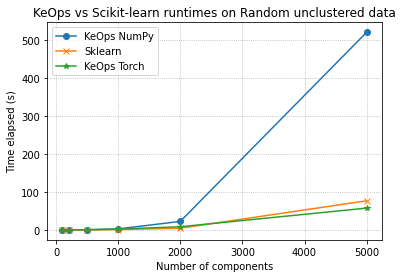

KeOps NumPy, 100 components, time taken: 0.02s.
KeOps Torch, 100 components, time taken: 0.01s.
Sklearn, 100 components, time taken: 0.01s.
KeOps NumPy, 200 components, time taken: 0.05s.
KeOps Torch, 200 components, time taken: 0.02s.
Sklearn, 200 components, time taken: 0.01s.
KeOps NumPy, 500 components, time taken: 0.58s.
KeOps Torch, 500 components, time taken: 0.14s.
Sklearn, 500 components, time taken: 0.13s.
KeOps NumPy, 1000 components, time taken: 3.38s.
KeOps Torch, 1000 components, time taken: 0.5s.
Sklearn, 1000 components, time taken: 0.69s.
KeOps NumPy, 2000 components, time taken: 22.94s.
KeOps Torch, 2000 components, time taken: 2.73s.
Sklearn, 2000 components, time taken: 4.28s.
KeOps NumPy, 5000 components, time taken: 468.17s.
KeOps Torch, 5000 components, time taken: 37.61s.
Sklearn, 5000 components, time taken: 78.56s.


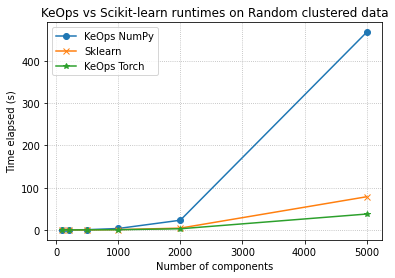

In [ ]:
# RUNTIMES FOR THE RBF KERNEL

get_runtime(random_data, random_data_t, 'Random unclustered data', 'rbf', 'rbf')
get_runtime(data_clustered, data_clustered_t, 'Random clustered data', 'rbf', 'rbf')

In [14]:
# Sklearn does not offer the exp kernel option, so needs to be defined manually
def exp_kernel(x,y):
    return np.exp(-np.sqrt( ( ((x - y) ** 2).sum(axis=-1) )))

KeOps NumPy, 100 components, time taken: 0.03s.
KeOps Torch, 100 components, time taken: 0.01s.
Sklearn, 100 components, time taken: 0.12s.
KeOps NumPy, 200 components, time taken: 0.1s.
KeOps Torch, 200 components, time taken: 0.02s.
Sklearn, 200 components, time taken: 0.21s.
KeOps NumPy, 500 components, time taken: 0.51s.
KeOps Torch, 500 components, time taken: 0.13s.
Sklearn, 500 components, time taken: 1.04s.
KeOps NumPy, 1000 components, time taken: 3.86s.
KeOps Torch, 1000 components, time taken: 0.41s.
Sklearn, 1000 components, time taken: 4.39s.


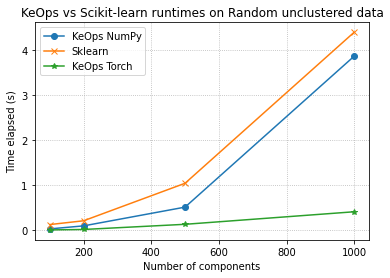

KeOps NumPy, 100 components, time taken: 0.03s.
KeOps Torch, 100 components, time taken: 0.0s.
Sklearn, 100 components, time taken: 0.13s.
KeOps NumPy, 200 components, time taken: 0.05s.
KeOps Torch, 200 components, time taken: 0.01s.
Sklearn, 200 components, time taken: 0.23s.
KeOps NumPy, 500 components, time taken: 0.64s.
KeOps Torch, 500 components, time taken: 0.1s.
Sklearn, 500 components, time taken: 1.04s.
KeOps NumPy, 1000 components, time taken: 3.91s.
KeOps Torch, 1000 components, time taken: 0.37s.
Sklearn, 1000 components, time taken: 4.46s.


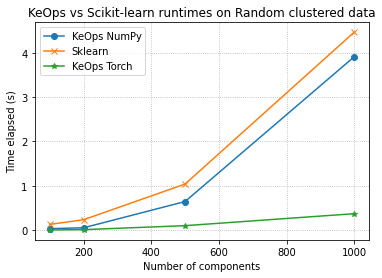

In [21]:
# RUNTIMES FOR THE EXP KERNEL

get_runtime(random_data, random_data_t, 'Random unclustered data', 'exp', exp_kernel)
get_runtime(data_clustered, data_clustered_t, 'Random clustered data', 'exp', exp_kernel)

In [35]:
# comparing KeOps & Sklearn outputs for the exp kernel 
# since the times above look suspiciously too good for us

nystrom = Nystrom_NK(kernel = 'exp', random_state = 0, n_components=500).fit(data_clustered)
x_n = nystrom.transform(data_clustered)

print("KeOps")
print(x_n, "\n")

nystrom_s = Nystroem(kernel= exp_kernel, n_components=500, random_state=0).fit(data_clustered)
x_ns = nystrom_s.transform(data_clustered)

print("Scikit-learn")
print(x_ns, "\n")

print("the error (difference between the transformed feature spaces) is", np.linalg.norm(x_n - x_ns))

KeOps
[[1.32936244e-04 3.65225595e-04 1.71457887e-02 ... 4.84089347e-02
  1.89764051e-04 1.14723412e-04]
 [1.14623972e-03 3.04480387e-05 1.27711986e-03 ... 7.40499422e-04
  1.56402847e-05 1.49515308e-05]
 [6.17845678e-04 2.87626965e-01 6.32462840e-04 ... 1.50369583e-04
  7.49332445e-02 2.82333700e-02]
 ...
 [8.96416904e-04 2.34865605e-03 2.72577170e-02 ... 4.45240041e-03
  1.04548250e-03 5.61117648e-04]
 [6.35072128e-04 9.82294010e-04 5.15965761e-02 ... 5.77956173e-03
  5.07000469e-04 2.49587187e-04]
 [1.41270628e-04 2.09445279e-04 2.04459068e-02 ... 1.27256446e-01
  1.04798420e-04 7.14425764e-05]] 

Scikit-learn
[[2.28977403e-06 1.04898985e-05 6.32760511e-03 ... 2.91271113e-02
  3.53187526e-06 1.48047359e-06]
 [7.87921221e-05 1.96023659e-07 9.43516093e-05 ... 3.43860675e-05
  6.40901962e-08 5.78527321e-08]
 [2.27903127e-05 2.92249173e-01 2.59348166e-05 ... 2.60757438e-06
  4.88983674e-02 1.17082783e-02]
 ...
 [4.47204261e-05 1.77048117e-04 1.13752979e-02 ... 7.88266933e-04
  4.3317532

KeOps NumPy, 100 components, time taken: 0.04s.
KeOps Torch, 100 components, time taken: 0.06s.
Sklearn, 100 components, time taken: 0.03s.
KeOps NumPy, 200 components, time taken: 0.24s.
KeOps Torch, 200 components, time taken: 0.18s.
Sklearn, 200 components, time taken: 0.03s.
KeOps NumPy, 500 components, time taken: 1.47s.
KeOps Torch, 500 components, time taken: 0.74s.
Sklearn, 500 components, time taken: 0.17s.
KeOps NumPy, 1000 components, time taken: 5.65s.
KeOps Torch, 1000 components, time taken: 1.91s.
Sklearn, 1000 components, time taken: 0.59s.


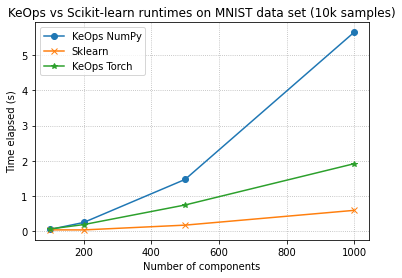

KeOps NumPy, 100 components, time taken: 0.04s.
KeOps Torch, 100 components, time taken: 0.03s.
Sklearn, 100 components, time taken: 0.14s.
KeOps NumPy, 200 components, time taken: 0.18s.
KeOps Torch, 200 components, time taken: 0.13s.
Sklearn, 200 components, time taken: 0.21s.
KeOps NumPy, 500 components, time taken: 1.02s.
KeOps Torch, 500 components, time taken: 0.46s.
Sklearn, 500 components, time taken: 1.25s.
KeOps NumPy, 1000 components, time taken: 5.07s.
KeOps Torch, 1000 components, time taken: 1.93s.
Sklearn, 1000 components, time taken: 5.23s.


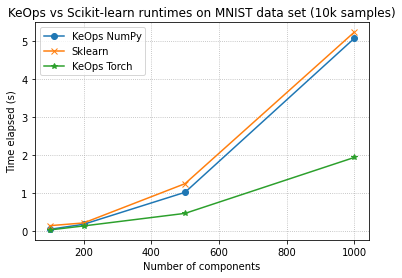

In [15]:
# Need to redefine NS here, because for MNIST the RAM cannot take >1000 components
NS = [
    100,
    200,
    500,
    1000
]

get_runtime(MNIST, MNIST_t, 'MNIST data set (10k samples)', 'rbf', 'rbf')
get_runtime(MNIST, MNIST_t, 'MNIST data set (10k samples)', 'exp', exp_kernel)

**Summary (Runtimes):** \\
* Looks like our code is doing quite a bit better (when compared to Sklearn) for data sets with small number of features

* Also looks like Sklearn is doing much better when using the gaussian kernel compared to a custom one (though the exp kernel perfomance should be further tested)

### **Average distance**


How can we assess the quality of the kernel approximation?

- simple method: take average distance between each point x and the closes basis point

- more advanced methods discussed in papers below:

https://www.jmlr.org/papers/volume6/drineas05a/drineas05a.pdf \\
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.149.6869&rep=rep1&type=pdf

To Do:
- look at how sampling affects the approximation quality (looks like it makes quite some difference, sklearn does random sampling though)

In [17]:
def get_avg_dist(data, data_t, data_name, keops_kernel, sklearn_kernel):
    ns = [50, 100, 200, 500, 1000] # corresponds to 5%, 10%, 20%, 50% and the full data set

    avg_dists = []
    for n_comp in ns:
        distances = []
        nystrom = Nystrom_NK(kernel = keops_kernel, random_state = 0, n_components=n_comp).fit(data)
        for sample in data:
            dist = min([np.linalg.norm(sample-b_sample) for b_sample in nystrom.components_])
            distances.append(dist)
        mean_dist = sum(distances) / len(distances)
        print(f"KeOps Numpy: The mean distance when sampling {n_comp} components is {round(mean_dist, 2)}.")
        avg_dists.append(mean_dist)
    
    avg_dists_2 = []
    for n_comp in ns:
        distances = []
        nystrom = Nystroem(kernel = sklearn_kernel, random_state = 0, n_components=n_comp).fit(data)
        for sample in data:
            dist = min([np.linalg.norm(sample-b_sample) for b_sample in nystrom.components_])
            distances.append(dist)
        mean_dist = sum(distances) / len(distances)
        print(f"Sklearn: The mean distance when sampling {n_comp} components is {round(mean_dist, 2)}.")
        avg_dists_2.append(mean_dist)

    avg_dists_3 = []
    for n_comp in ns:
        distances = []
        nystrom = Nystrom_TK(kernel = keops_kernel, random_state = 0, n_components=n_comp).fit(data_t)
        for sample in data_t:
            dist = min([np.linalg.norm(sample-b_sample) for b_sample in nystrom.components_])
            distances.append(dist)
        mean_dist = sum(distances) / len(distances)
        print(f"KeOps Torch: The mean distance when sampling {n_comp} components is {round(mean_dist, 2)}.")
        avg_dists_3.append(mean_dist)

    plt.plot(ns, avg_dists, marker ="o", label = 'KeOps NumPy')
    plt.plot(ns, avg_dists_2, marker = "x", label = 'Sklearn')
    plt.plot(ns, avg_dists_3, marker = "*", label = 'KeOps Torch')

    plt.legend()
    plt.xlabel("Number of components")
    plt.ylabel("Distance (absolute)")
    plt.title(f"Mean distance from nearest neighbour based on n_components on {data_name}")
    plt.grid(True, which="major", linestyle="dotted")
    plt.show()

The mean distance when sampling 50 components is 16.1.
The mean distance when sampling 100 components is 11.66.
The mean distance when sampling 200 components is 7.89.
The mean distance when sampling 500 components is 3.6.
The mean distance when sampling 1000 components is 0.0.
The mean distance when sampling 50 components is 16.1.
The mean distance when sampling 100 components is 11.66.
The mean distance when sampling 200 components is 7.89.
The mean distance when sampling 500 components is 3.6.
The mean distance when sampling 1000 components is 0.0.
The mean distance when sampling 50 components is 16.1.
The mean distance when sampling 100 components is 11.66.
The mean distance when sampling 200 components is 7.89.
The mean distance when sampling 500 components is 3.6.
The mean distance when sampling 1000 components is 0.0.


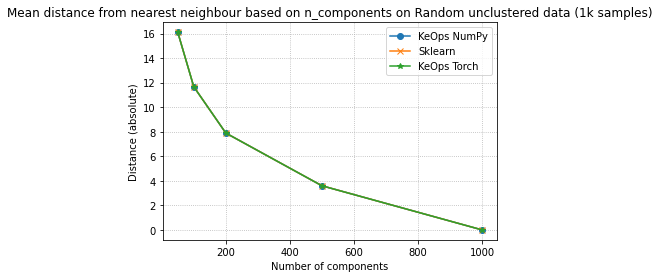

The mean distance when sampling 50 components is 1.02.
The mean distance when sampling 100 components is 0.79.
The mean distance when sampling 200 components is 0.56.
The mean distance when sampling 500 components is 0.27.
The mean distance when sampling 1000 components is 0.0.
The mean distance when sampling 50 components is 1.02.
The mean distance when sampling 100 components is 0.79.
The mean distance when sampling 200 components is 0.56.
The mean distance when sampling 500 components is 0.27.
The mean distance when sampling 1000 components is 0.0.
The mean distance when sampling 50 components is 1.02.
The mean distance when sampling 100 components is 0.79.
The mean distance when sampling 200 components is 0.56.
The mean distance when sampling 500 components is 0.27.
The mean distance when sampling 1000 components is 0.0.


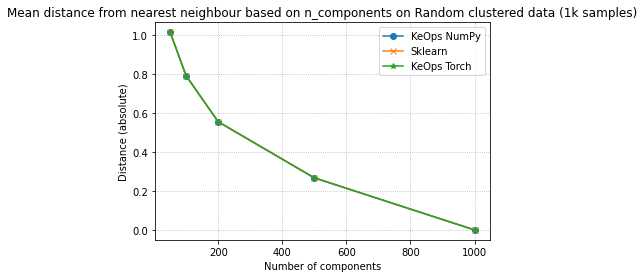

The mean distance when sampling 50 components is 22.08.
The mean distance when sampling 100 components is 19.78.
The mean distance when sampling 200 components is 16.52.
The mean distance when sampling 500 components is 9.58.
The mean distance when sampling 1000 components is 0.0.
The mean distance when sampling 50 components is 22.08.
The mean distance when sampling 100 components is 19.78.
The mean distance when sampling 200 components is 16.52.
The mean distance when sampling 500 components is 9.58.
The mean distance when sampling 1000 components is 0.0.
The mean distance when sampling 50 components is 22.08.
The mean distance when sampling 100 components is 19.78.
The mean distance when sampling 200 components is 16.52.
The mean distance when sampling 500 components is 9.58.
The mean distance when sampling 1000 components is 0.0.


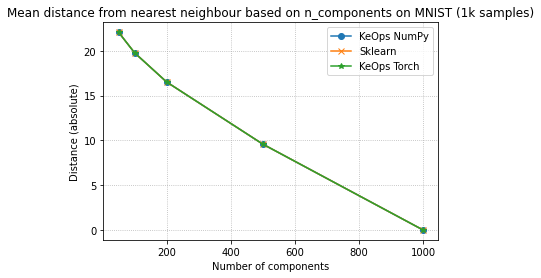

In [42]:
# AVERAGE DISTANCES FOR THE RBF KERNEL

get_avg_dist(random_data[:1000], random_data_t[:1000], 'Random unclustered data (1k samples)', 'rbf', 'rbf')
get_avg_dist(data_clustered[:1000], data_clustered_t[:1000], 'Random clustered data (1k samples)', 'rbf', 'rbf')
get_avg_dist(MNIST[:1000], MNIST_t[:1000], 'MNIST (1k samples)', 'rbf', 'rbf')

KeOps Numpy: The mean distance when sampling 50 components is 15.33.
KeOps Numpy: The mean distance when sampling 100 components is 11.87.
KeOps Numpy: The mean distance when sampling 200 components is 8.04.
KeOps Numpy: The mean distance when sampling 500 components is 3.75.
KeOps Numpy: The mean distance when sampling 1000 components is 0.0.
Sklearn: The mean distance when sampling 50 components is 15.33.
Sklearn: The mean distance when sampling 100 components is 11.87.
Sklearn: The mean distance when sampling 200 components is 8.04.
Sklearn: The mean distance when sampling 500 components is 3.75.
Sklearn: The mean distance when sampling 1000 components is 0.0.
KeOps Torch: The mean distance when sampling 50 components is 15.33.
KeOps Torch: The mean distance when sampling 100 components is 11.87.
KeOps Torch: The mean distance when sampling 200 components is 8.04.
KeOps Torch: The mean distance when sampling 500 components is 3.75.
KeOps Torch: The mean distance when sampling 1000 c

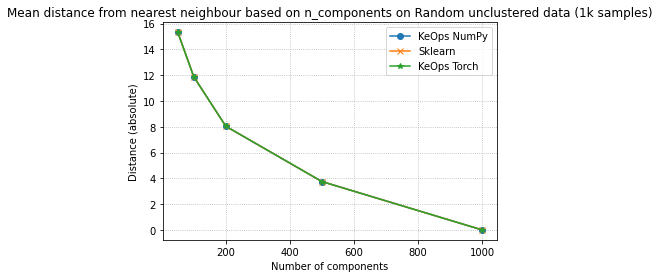

KeOps Numpy: The mean distance when sampling 50 components is 0.99.
KeOps Numpy: The mean distance when sampling 100 components is 0.74.
KeOps Numpy: The mean distance when sampling 200 components is 0.54.
KeOps Numpy: The mean distance when sampling 500 components is 0.25.
KeOps Numpy: The mean distance when sampling 1000 components is 0.0.
Sklearn: The mean distance when sampling 50 components is 0.99.
Sklearn: The mean distance when sampling 100 components is 0.74.
Sklearn: The mean distance when sampling 200 components is 0.54.
Sklearn: The mean distance when sampling 500 components is 0.25.
Sklearn: The mean distance when sampling 1000 components is 0.0.
KeOps Torch: The mean distance when sampling 50 components is 0.99.
KeOps Torch: The mean distance when sampling 100 components is 0.74.
KeOps Torch: The mean distance when sampling 200 components is 0.54.
KeOps Torch: The mean distance when sampling 500 components is 0.25.
KeOps Torch: The mean distance when sampling 1000 compone

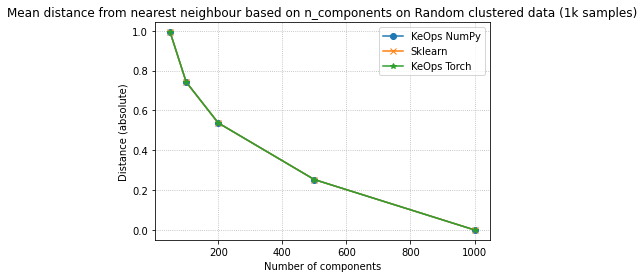

KeOps Numpy: The mean distance when sampling 50 components is 22.26.
KeOps Numpy: The mean distance when sampling 100 components is 19.85.
KeOps Numpy: The mean distance when sampling 200 components is 16.71.
KeOps Numpy: The mean distance when sampling 500 components is 9.82.
KeOps Numpy: The mean distance when sampling 1000 components is 0.0.
Sklearn: The mean distance when sampling 50 components is 22.26.
Sklearn: The mean distance when sampling 100 components is 19.85.
Sklearn: The mean distance when sampling 200 components is 16.71.
Sklearn: The mean distance when sampling 500 components is 9.82.
Sklearn: The mean distance when sampling 1000 components is 0.0.
KeOps Torch: The mean distance when sampling 50 components is 22.26.
KeOps Torch: The mean distance when sampling 100 components is 19.85.
KeOps Torch: The mean distance when sampling 200 components is 16.71.
KeOps Torch: The mean distance when sampling 500 components is 9.82.
KeOps Torch: The mean distance when sampling 100

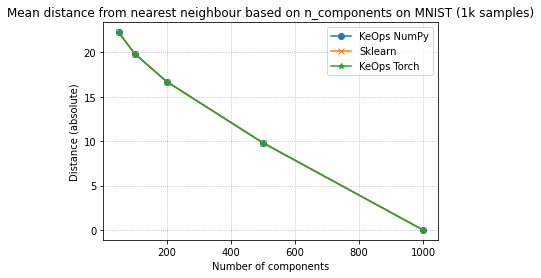

In [18]:
# AVERAGE DISTANCES FOR THE RBF KERNEL

get_avg_dist(random_data[:1000], random_data_t[:1000], 'Random unclustered data (1k samples)', 'exp', exp_kernel)
get_avg_dist(data_clustered[:1000], data_clustered_t[:1000], 'Random clustered data (1k samples)', 'exp', exp_kernel)
get_avg_dist(MNIST[:1000], MNIST_t[:1000], 'MNIST (1k samples)', 'exp', exp_kernel) # shuffled already

**Summary (avg distance):** \\
Differences resulting from random seed selection are minor. \\
As of now, this is not saying as much because it depends on the data scale etc, but if we implement more sophisticated sampling, it will be useful to compare the mean distance given the same data but different sampling.

Right now Sklearn hasthe same distances, but we could improve by better sampling, but this is very likely to be computationally too expensive to be worth it.

### **Kernel approximation Error**

**Notes:** \\

* Add in errors for exp kernel
* Add in errors for all the data sets

KeOps Torch: For 50 components the approximation error is 1429.8822069412906.
KeOps Numpy: For 50 components the approximation error is 779.5923170357854.
KeOps Torch: For 100 components the approximation error is 2032.4439627915635.
KeOps Numpy: For 100 components the approximation error is 829.8586111506759.
KeOps Torch: For 200 components the approximation error is 2910.897431778395.
KeOps Numpy: For 200 components the approximation error is 852.9142156329316.
KeOps Torch: For 500 components the approximation error is 4430.506259551283.
KeOps Numpy: For 500 components the approximation error is 859.4527198865914.
KeOps Torch: For 1000 components the approximation error is 6255.338742784803.
KeOps Numpy: For 1000 components the approximation error is 859.6839414287073.
KeOps Torch: For 2000 components the approximation error is 8847.559628709352.
KeOps Numpy: For 2000 components the approximation error is 859.706988555013.
KeOps Torch: For 5000 components the approximation error is 1

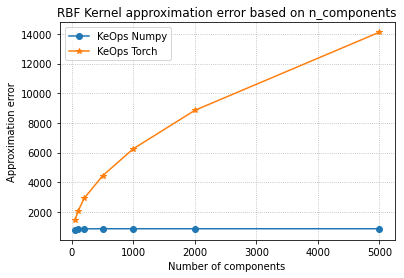

In [22]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.kernel_approximation import Nystroem

length = 5000

use_cuda = torch.cuda.is_available()

NS = [50, 100, 200, 500, 1000, 2000, 5000]
errors_n = []
errors_t = []

k = rbf_kernel(X)

   
for n_comps in NS:

    # keops Torch
    nystrom = Nystrom_TK(kernel = 'rbf', random_state = 0, n_components=n_comps).fit(data_clustered_t[:5000])
    k_approx = nystrom.K_approx(data_clustered_t[:5000]).detach().cpu().numpy()
    # error = np.linalg.norm(k-k_approx) / k.shape[0]
    error = np.linalg.norm(k-k_approx)
    errors_t.append(error)
    print(f"KeOps Torch: For {n_comps} components the approximation error is {error}.")

    # keops Numpy
    nystrom = Nystrom_NK(kernel = 'rbf', random_state = 0, n_components=n_comps).fit(data_clustered[:5000])
    k_approx = nystrom.K_approx(data_clustered[:5000])
    # error = np.linalg.norm(k-k_approx)/ k.size
    error = np.linalg.norm(k-k_approx)
    errors_n.append(error)
    print(f"KeOps Numpy: For {n_comps} components the approximation error is {error}.")

plt.plot(NS, errors_n, marker ="o", label = 'KeOps Numpy')
plt.plot(NS, errors_t, marker ="*", label = 'KeOps Torch')
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Approximation error")
plt.title("RBF Kernel approximation error based on n_components")
plt.grid(True, which="major", linestyle="dotted")
plt.show()